In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import copy
import torch
from torchvision import transforms
from utils import FaceDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
data = FaceDataset("data")

cuda:0


In [2]:
train_size = int(0.9*len(data))
train_data, test_data = random_split(data, [train_size, len(data)-train_size])
valid_size = int(0.1*len(train_data))
train_data, valid_data = random_split(train_data, [len(train_data)-valid_size,
                                                   valid_size])


In [3]:
train_data_loader = DataLoader(dataset= train_data,batch_size=10, shuffle=True, 
                               drop_last=True)
valid_data_loader = DataLoader(dataset= valid_data,batch_size=10, shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True, 
                              drop_last=True)

In [4]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        #self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.act_fn = act_fn

    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply sequentially the input, hidden, and output layer, as we did in the example before.
        #x = x.view(-1, 784)
        sigmoid = nn.Sigmoid()
        dropout = nn.Dropout(p=0.1)
        x = dropout(self.act_fn(self.hidden1(x)))
        x = dropout(self.act_fn(self.hidden2(x)))
        #x = self.act_fn(self.hidden3(x))
        out = sigmoid(self.out_layer(x))
        return out

In [5]:
model = MLPClassif(30*30, 64, 1, nn.ReLU())


In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

torch.manual_seed(0)
model.apply(init_weights)
#model.to(device)

MLPClassif(
  (hidden1): Linear(in_features=900, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=1, bias=True)
  (act_fn): ReLU()
)

In [7]:

def eval_binary_classifier(model, eval_dataloader, loss_fn):
    #model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 
    #model.to(device)
    transform = transforms.Resize(size = (30,30))
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss = 0

        

        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:
            images = torch.tensor(images, dtype=float)
            images = transform(images)
            labels = labels.unsqueeze(1).float()
            #labels.to(device)
            images = images.reshape(images.shape[0], -1).type(torch.float)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images)

            l =loss_fn(y_predicted, labels)
            loss += l.item()
            

    return loss

def train_val_binary_classifier(model, train_dataloader, valid_dataloader, num_epochs, 
                            loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #model_tr.to(device)
    # Define the optimizer
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss = []
    min_valid_loss = 0
    transform = transforms.Resize(size = (30,30))
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #images.to(device)
            images = torch.tensor(images, dtype=float)
            images = transform(images)
            

            labels = torch.Tensor([(l==1) for l in labels]).unsqueeze(1).float()
            #labels.to(device)
            images = images.reshape(images.shape[0], -1).type(torch.float)
            
            y_pred = model_tr(images)
            
            l = loss_fn(y_pred, labels)
            #print(y_pred.shape, labels.shape)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()



        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        val_loss= eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)

        if val_loss < min_valid_loss:
            min_valid_loss = val_loss
            torch.save(model_tr.state_dict(), 'model_opt.pt')
                                    
        if verbose:
            print('Epoch [{}/{}], Train Loss: {:.4f}\n\
                Valid Loss: {:.4f}'.format(epoch+1, num_epochs, 
                                           loss_current_epoch,
                                           val_loss))

            
        
    return model_tr, loss_all_epochs, valid_loss

In [8]:
num_epochs = 150
learning_rate = 0.05
loss_fn = nn.BCELoss()
model_trained, train_losses, val_losses =train_val_binary_classifier(model, 
                                                                     train_data_loader,
                                                                     valid_data_loader,
                                                                     num_epochs,loss_fn, 
                                                                     learning_rate, 
                                                                     verbose=True)

/tmp/ipykernel_12015/2439641732.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=float)
/tmp/ipykernel_12015/2439641732.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=float)


Epoch [1/150], Train Loss: 228.9592
                Valid Loss: 24.5653
Epoch [2/150], Train Loss: 223.6322
                Valid Loss: 24.2407
Epoch [3/150], Train Loss: 220.6014
                Valid Loss: 24.2774
Epoch [4/150], Train Loss: 217.4614
                Valid Loss: 27.4658
Epoch [5/150], Train Loss: 214.9772
                Valid Loss: 24.2455
Epoch [6/150], Train Loss: 212.9780
                Valid Loss: 25.4379
Epoch [7/150], Train Loss: 209.2260
                Valid Loss: 24.1582
Epoch [8/150], Train Loss: 207.4767
                Valid Loss: 23.2363
Epoch [9/150], Train Loss: 205.5991
                Valid Loss: 24.3013
Epoch [10/150], Train Loss: 202.9692
                Valid Loss: 26.4882
Epoch [11/150], Train Loss: 199.2379
                Valid Loss: 23.4696
Epoch [12/150], Train Loss: 197.9351
                Valid Loss: 22.9781
Epoch [13/150], Train Loss: 195.0978
                Valid Loss: 22.9779
Epoch [14/150], Train Loss: 191.7970
                Valid L

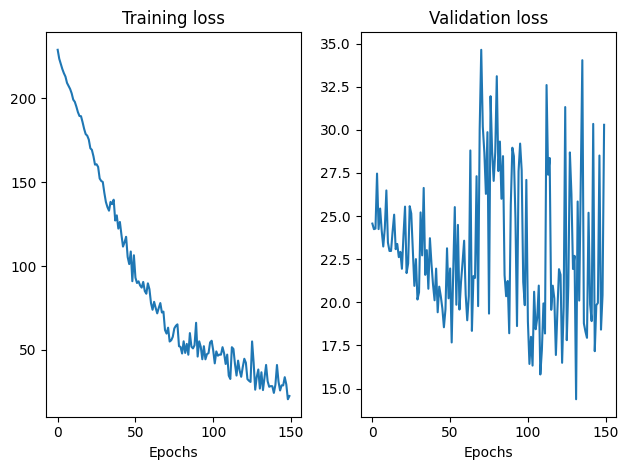

In [9]:
# Plot the training and validation losses over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(val_losses)
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [10]:
def eval_classifier(model, eval_dataloader):

    # Set the model in evaluation mode
    model.eval() 
    transform = transforms.Resize(size = (30,30))
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            images = torch.tensor(images, dtype=float)
            images = transform(images)
            labels = labels.unsqueeze(1).float()
            
            #label.to(device)
            images = images.reshape(images.shape[0], -1).type(torch.float)
            y_predicted = model(images)
            label_predicted = torch.round(y_predicted)
            #print(label_predicted)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [14]:
#model_ =  MLPClassif(30*30, 32, 1, nn.ReLU())
#model_.load_state_dict(torch.load('model_opt.pt'))
torch.save(model_trained, 'model_opt.pt')
eval_classifier(model_trained, test_data_loader)

/tmp/ipykernel_12015/4269401277.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=float)


79.5